**Authors**: Céline Hirsch, Sandra Frey, Sina Röllin

**Deep Learning Project**: Inclusiveness in Sarcasm Detection

# Final Model Spectrograms

In [1]:
from functions_audio_model_tiny import *
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
import json
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean

Let's define some classes and functions needed in the training pipeline.

In [2]:
class SpectrogramDataset(Dataset):
    def __init__(self, spectrogram_dir, labels):
        self.spectrogram_dir = spectrogram_dir
        self.file_list = [f for f in os.listdir(spectrogram_dir) if f.endswith('_red.npy')]
        self.labels = labels  #dictionary mapping base file names to labels

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        #to get the base name of the file (without the color channel)
        base_name = self.file_list[idx].replace('_red.npy', '')

        #All colour channels separately
        red_channel = np.load(os.path.join(self.spectrogram_dir, base_name + '_red.npy'))
        green_channel = np.load(os.path.join(self.spectrogram_dir, base_name + '_green.npy'))
        blue_channel = np.load(os.path.join(self.spectrogram_dir, base_name + '_blue.npy'))

        #Stack the color channels to create RGB image
        spectrogram = np.stack((red_channel, green_channel, blue_channel), axis=2)

        #Conversion to tensor
        spectrogram = torch.from_numpy(spectrogram)

        #Normalisation to range [-1, 1]
        spectrogram = (spectrogram - 0.5) * 2

        #Label
        label = self.labels[base_name]

        return spectrogram, label

First we have to load the sarcasm labels. We can extract these from the datasets created for the text model.

In [3]:
# Load labels for sarcasm detection (from a different file, not part of the spectrograms folder)
with open('data/audio/labels_mixed.json', 'r') as f:
    mixed_labels = json.load(f)

with open('data/audio/labels_F.json', 'r') as f:
    F_labels = json.load(f)

with open('data/audio/labels_M.json', 'r') as f:
    M_labels = json.load(f)

We can now initialize the Datasets, by combining the sarcasm labels with the audio data in the form of spectrograms, as prepared in `audio-data-preparation.ipynb`.

In [4]:
# Initialise the datasets
mixed_dataset = SpectrogramDataset('data/spectrograms/spectrograms_mixed/', mixed_labels)
M_dataset = SpectrogramDataset('data/spectrograms/spectrograms_M/', M_labels)
F_dataset = SpectrogramDataset('data/spectrograms/spectrograms_F/', F_labels)

We will now train 3 different models: 
- one model will be trained on the mixed data
- one model will be trained on spectrograms from female speakers only
- one model will be trained on spectrograms from male speakers only


Start of epoch 0
Training acc over epoch: 0.5756
Training F1 score over epoch: 0.5182
Training loss over epoch: 0.6681
Validation acc: 0.6570
Validation F1 score: 0.5629
Validation loss: 0.6525

Start of epoch 1
Training acc over epoch: 0.6163
Training F1 score over epoch: 0.6068
Training loss over epoch: 0.6171
Validation acc: 0.6250
Validation F1 score: 0.6054
Validation loss: 0.6534

Start of epoch 2
Training acc over epoch: 0.6386
Training F1 score over epoch: 0.6262
Training loss over epoch: 0.5959
Validation acc: 0.6240
Validation F1 score: 0.6267
Validation loss: 0.6543


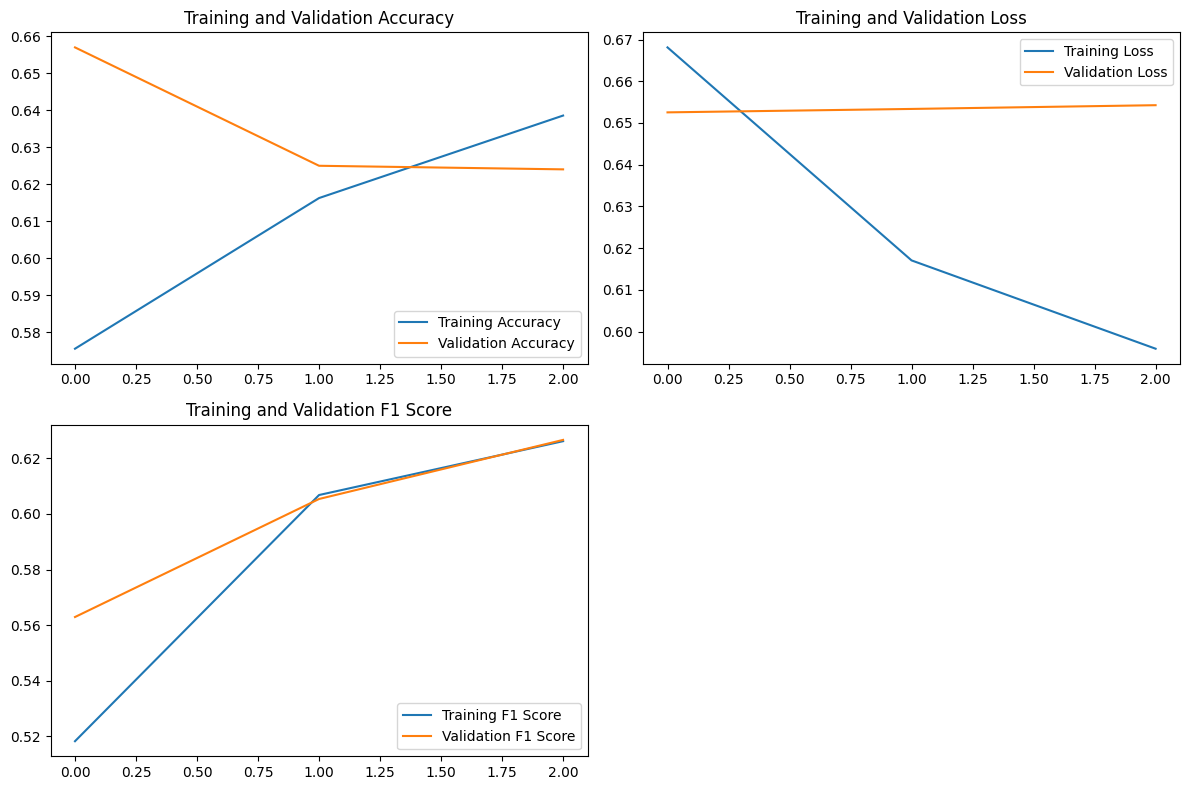

In [5]:
# MIXED MODEL

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.00001
num_epochs = 3
batch_size = 32
weight_decay = 0.1
dropout_prob = 0.2

# Split dataset into training and testing
train_size = int(0.8 * len(mixed_dataset))  # 80% of the data for training
test_size = len(mixed_dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(mixed_dataset, [train_size, test_size])

# Initialize the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model (pre-trained MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Two classes for classification

mixed_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the optimizer
optimizer = Adam(learning_rate=learning_rate)

# Define the loss function
loss_fn = SparseCategoricalCrossentropy()

# Define the metrics
train_acc_metric = SparseCategoricalAccuracy()
val_acc_metric = SparseCategoricalAccuracy()

train_accs, val_accs, train_losses, val_losses, train_f1s, val_f1s = train_cycle(mixed_model, optimizer, loss_fn, train_acc_metric, val_acc_metric, train_dataloader, test_dataloader, epochs=num_epochs)
name = 'plot1.png'
plot_metrics(train_accs, val_accs, train_losses, val_losses, train_f1s, val_f1s, plot_name=name)

# Save the model weights
mixed_model.save('models/mixed_model_audio.h5')

In [ ]:
# FEMALE MODEL

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.00001
num_epochs = 29
batch_size = 32
weight_decay = 0.1
dropout_prob = 0.2

# Split dataset into training and testing
train_size = int(0.8 * len(F_dataset))  # 80% of the data for training
test_size = len(F_dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(F_dataset, [train_size, test_size])

# Initialize the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model (pre-trained MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Two classes for classification

F_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the optimizer
optimizer = Adam(learning_rate=learning_rate)

# Define the loss function
loss_fn = SparseCategoricalCrossentropy()

# Define the metrics
train_acc_metric = SparseCategoricalAccuracy()
val_acc_metric = SparseCategoricalAccuracy()

train_accs, val_accs, train_losses, val_losses, train_f1s, val_f1s = train_cycle(F_model, optimizer, loss_fn, train_acc_metric, val_acc_metric, train_dataloader, test_dataloader, epochs=num_epochs)
plot_metrics(train_accs, val_accs, train_losses, val_losses, train_f1s, val_f1s)

# Save the model weights
F_model.save('models/F_model_audio.h5')

In [ ]:
# MALE MODEL

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.00001
num_epochs = 29
batch_size = 32
weight_decay = 0.1
dropout_prob = 0.2

# Split dataset into training and testing
train_size = int(0.8 * len(M_dataset))  # 80% of the data for training
test_size = len(M_dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(M_dataset, [train_size, test_size])

# Initialize the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model (pre-trained MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Two classes for classification

M_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the optimizer
optimizer = Adam(learning_rate=learning_rate)

# Define the loss function
loss_fn = SparseCategoricalCrossentropy()

# Define the metrics
train_acc_metric = SparseCategoricalAccuracy()
val_acc_metric = SparseCategoricalAccuracy()

train_accs, val_accs, train_losses, val_losses, train_f1s, val_f1s = train_cycle(M_model, optimizer, loss_fn, train_acc_metric, val_acc_metric, train_dataloader, test_dataloader, epochs=num_epochs)
plot_metrics(train_accs, val_accs, train_losses, val_losses, train_f1s, val_f1s)

# Save the model weights
M_model.save('models/M_model_audio.h5')